# Massey ranking

Description: Construct a Massey ranking of data.
  
Created by Tim Chartier

### Set parameters

gameFilename - game data file, presumed to be in the format from 
the Massey rating data server, which can be found at 
http://www.masseyratings.com/. 

teamFilename - team data file

k - number of teams to print in the final ranking - set to 0 to get all teams

In [1]:
gameFilename = 'data/2021games.txt'
teamFilename = 'data/2021teams.txt'
k = 10

### Load the team names into an array

In [2]:
import pandas as pd

teamNames = pd.read_csv(teamFilename, header = None)
numTeams = len(teamNames)

### Load the games

In [3]:
# columns of games are:
#	column 0 = days since 1/1/0000
#	column 1 = date in YYYYMMDD format
#	column 2 = team1 index
#	column 3 = team1 homefield (1 = home, -1 = away, 0 = neutral)
#	column 4 = team1 score
#	column 5 = team2 index
#	column 6 = team2 homefield (1 = home, -1 = away, 0 = neutral)
#	column 7 = team2 score
games = pd.read_csv(gameFilename, header = None)
numGames = len(games)

### Create the Massey linear system

In [18]:
import numpy as np

masseyMatrix = np.zeros((numTeams,numTeams))
b = np.zeros(numTeams)

for i in range(numGames):
    team1ID = games.loc[i, 2] - 1 # subtracting 1 since python indexes at 0
    team1Score = games.loc[i, 4]
    team2ID = games.loc[i, 5] - 1 # subtracting 1 since python indexes at 0
    team2Score = games.loc[i, 7]
    
    masseyMatrix[team1ID, team2ID] -= 1
    masseyMatrix[team2ID, team1ID] -= 1

    masseyMatrix[team1ID, team1ID] += 1
    masseyMatrix[team2ID, team2ID] += 1
    
    pointDifferential = abs(team1Score - team2Score)
    
    if team1Score > team2Score:
        b[team1ID] += pointDifferential
        b[team2ID] -= pointDifferential
    elif team1Score < team2Score:
        b[team1ID] -= pointDifferential
        b[team2ID] += pointDifferential
        
# replace last row with ones and 0 on RHS
masseyMatrix[-1,:] = np.ones((1,numTeams))
b[-1] = 0
print(b)

[ 167.  105.  324. -139.  -64. -608.  163.  355. -322.   76. -569.   -3.
  445.  201.   74.    2.  424. -400.  -21.  166. -766. -670.  402.  419.
  129. -265. -125.  -34.  666.    0.]


In [20]:
colleyMatrix = 2*np.diag(np.ones(numTeams))
c = np.ones(numTeams)

for i in range(numGames):
    team1ID = games.loc[i, 2] - 1 # subtracting 1 since python indexes at 0
    team1Score = games.loc[i, 4]
    team2ID = games.loc[i, 5] - 1 # subtracting 1 since python indexes at 0
    team2Score = games.loc[i, 7]
    
    colleyMatrix[team1ID, team2ID] -= 1
    colleyMatrix[team2ID, team1ID] -= 1

    colleyMatrix[team1ID, team1ID] += 1
    colleyMatrix[team2ID, team2ID] += 1
    
    if team1Score > team2Score:
        c[team1ID] += 1/2
        c[team2ID] -= 1/2
    elif team1Score < team2Score:
        c[team1ID] -= 1/2
        c[team2ID] += 1/2
    else:  # it is a tie and make 1/2 a win and 1/2 a loss for both teams
        c[team1ID] += 0; # this equates to adding nothing
        c[team2ID] += 0; # clearly this code could be deleted
        
print(c)

[  6.   1.  13.  -2.  -4. -13.   7.  12. -15.   4. -18.  -1.  12.   7.
   3.   5.  11. -12.  -4.   6. -13. -14.  14.  16.   7.  -4.  -2.  -8.
  17.  -1.]


### Calculate linear system

In [22]:
#Massey
r = np.linalg.solve(masseyMatrix,b)
iSort = np.argsort(-r)
print(r)
#Colley
r2 = np.linalg.solve(colleyMatrix,b)

[  2.14177778   1.31511111   4.23511111  -1.93822222  -0.93822222
  -8.19155556   2.25822222   4.81822222  -4.37822222   1.09822222
  -7.50177778  -0.12488889   6.01822222   2.76488889   1.07155556
  -0.05822222   5.56844444  -5.24844444  -0.19511111   2.12844444
 -10.12844444  -9.01822222   5.27511111   5.67155556   1.80488889
  -3.44844444  -1.58177778  -0.53822222   8.96488889  -1.84488889]


### Print the ranking of the teams

In [6]:
print('\n\n************** MASSEY Rating Method **************\n')
print('===========================')
print('Rank   Rating    Team   ')
print('===========================')
if k==0:
    numberTeamToPrint = numTeams
else:
    numberTeamToPrint = k

for i in range(numberTeamToPrint):
    print(f'{i+1:4d}   {r[iSort[i]]:.5f}  {teamNames.loc[iSort[i],1]}')

print('')   # extra carriage return



************** MASSEY Rating Method **************

Rank   Rating    Team   
   1   8.96489   Utah
   2   6.01822   LA_Clippers
   3   5.67156   Phoenix
   4   5.56844   Milwaukee
   5   5.27511   Philadelphia
   6   4.81822   Denver
   7   4.23511   Brooklyn
   8   2.76489   LA_Lakers
   9   2.25822   Dallas
  10   2.14178   Atlanta



### Calculate predictability of method

In [7]:
numberCorrectPredictions = 0
for i in range(numGames):
    team1ID = games.loc[i, 2] - 1 
    team1Score = games.loc[i, 4]
    team2ID = games.loc[i, 5] - 1 
    team2Score = games.loc[i, 7]
    
    if team1Score > team2Score and r[team1ID] > r[team2ID]:
        numberCorrectPredictions += 1
    elif team2Score > team1Score and r[team2ID] > r[team1ID]:
        numberCorrectPredictions += 1
    elif team1Score == team2Score and r[team1ID] == r[team2ID]:
        numberCorrectPredictions += 1

print(f'Predictability: {numberCorrectPredictions/numGames*100:.2f}%') 


Predictability: 74.88%


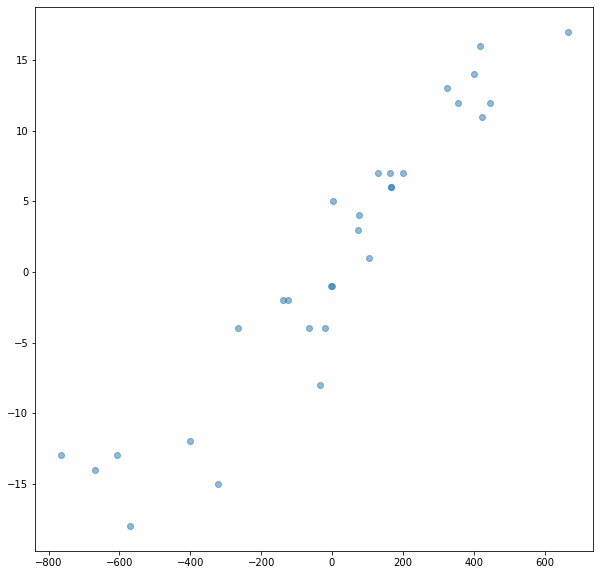

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(b, c, alpha=0.5)


[  2.14177778   1.31511111   4.23511111  -1.93822222  -0.93822222
  -8.19155556   2.25822222   4.81822222  -4.37822222   1.09822222
  -7.50177778  -0.12488889   6.01822222   2.76488889   1.07155556
  -0.05822222   5.56844444  -5.24844444  -0.19511111   2.12844444
 -10.12844444  -9.01822222   5.27511111   5.67155556   1.80488889
  -3.44844444  -1.58177778  -0.53822222   8.96488889  -1.84488889]
[ 4.24549644  3.44030163  6.28445748  0.27147047  1.24549644 -5.81943863
  4.32593213  6.81943863 -2.10515291  3.196062   -5.18056137  2.03770423
  7.98826979  4.81943863  3.17008798  2.1026393   7.58315878 -2.98575618
  1.93632174  4.23250943 -7.73900293 -6.62463343  7.29744449  7.65060746
  3.88437369 -1.23250943  0.58567239  1.63510683 10.85839966  2.07666527]


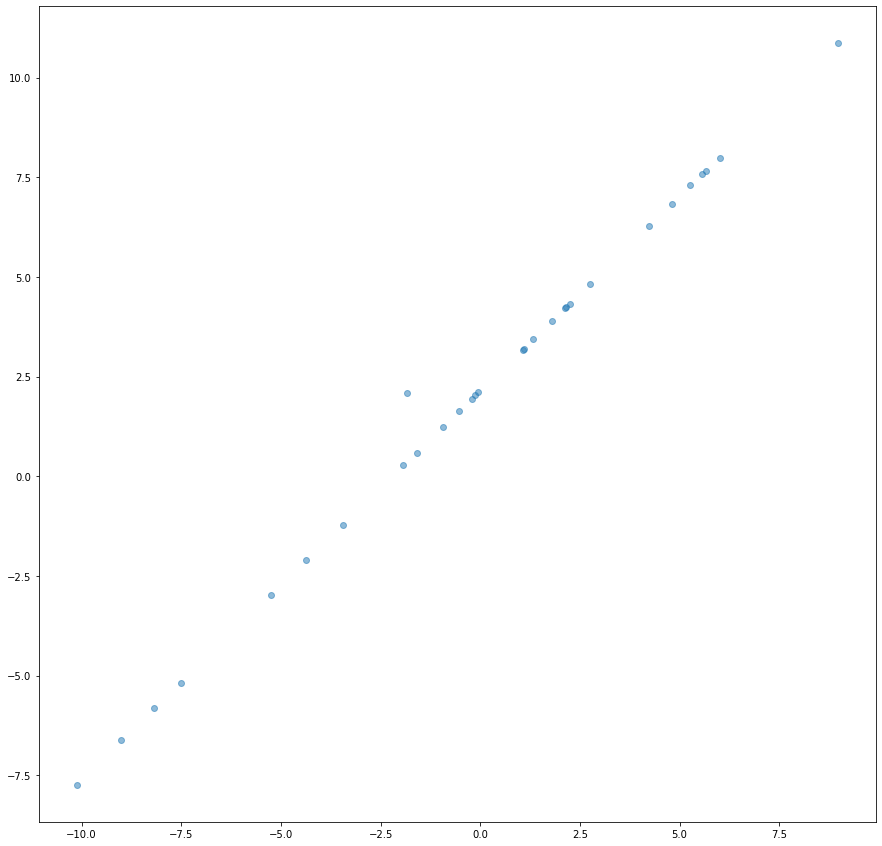

In [38]:
print(r)
print(r2)
plt.figure(figsize=(15, 15))
plt.scatter(r, r2, alpha=0.5)